# Reconstructing Temperature Response Functions
Look at how selecting certain elements/ions impacts predictions of the intensity as compared to the actual temperature response functions.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import seaborn
import astropy.units as u
import fiasco
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.atomic import Element,Ion,EmissionModel,list_elements

%matplotlib inline

In [5]:
temperature = 10.**(np.arange(5,8.1,0.1))*u.K
density = np.logspace(15-np.log10(temperature.value.max()),15-np.log10(temperature.value.min()),5)/(u.cm**3)

In [6]:
ions = None
for el in list_elements():
    if ions is None:
        ions = Element(el,temperature)
    else:
        ions += Element(el,temperature)


In [7]:
em_model = EmissionModel(density,ions)

In [9]:
em_model.calculate_emissivity('/Users/willbarnes/Desktop/emiss_table.h5')

A Jupyter Widget

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev486-py3.6.egg/synthesizAR/atomic/chianti.py:78: RuntimeWarning: invalid value encountered in greater
  ex_rate = u.Quantity(np.where(ex_rate > 0., ex_rate, 0.), u.cm**3/u.s).T


In [41]:
aia = InstrumentSDOAIA([0,1]*u.s)

In [42]:
calc_temp_response = {}
for channel in aia.channels:
    counts = np.zeros(em_model.temperature.shape+em_model.density.shape)
    for ion in em_model:
        if ion.element_name != 'iron':
            continue
        wvl,emiss = em_model.get_emissivity(ion)
        if wvl is None or emiss is None:
            continue
        response = scipy.interpolate.splev(wvl.value,channel['wavelength_response_spline'])
        response = np.where(response < 0., 0., response)
        tmp = np.dot(emiss.value,response)
        try:
            ab = ion._abundance['sun_coronal_1992_feldman'].value
        except IndexError:
            ab = ion.abundance.value
        tmp *= ab*ion.ioneq.value[:,np.newaxis]/em_model.density.value/4./np.pi
        counts += tmp
    calc_temp_response[channel['name']] = counts

In [43]:
const_p_indices = np.array([(i,np.argmin(np.fabs(em_model.density.value-d.value))) 
                            for i,d in enumerate(1e15/em_model.temperature)])

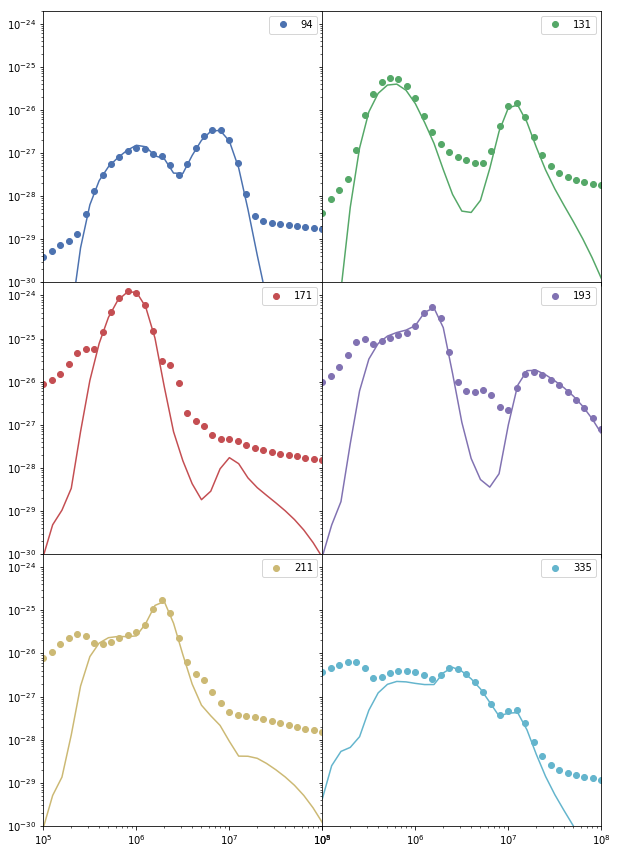

In [44]:
fig,axes = plt.subplots(3,2,figsize=(10,15),sharex=True,sharey=True)
data_temperature = np.logspace(5,8,100)
for i,(ax,channel) in enumerate(zip(axes.flatten(),aia.channels)):
    real_response = scipy.interpolate.splev(data_temperature,channel['temperature_response_spline'])
    ax.plot(data_temperature,real_response,
            'o',markevery=3,color=seaborn.color_palette('deep')[i],label=channel['name'])
    ax.plot(em_model.temperature,calc_temp_response[channel['name']][const_p_indices[:,0],const_p_indices[:,1]],
             color=seaborn.color_palette('deep')[i],ls='-')
    #ax.axvline(x=1e6,ls='--',color='k')
    #ax.axvline(x=1e7,ls='--',color='k')
    ax.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-30,2e-24])
plt.xlim([1e5,1e8])
#plt.legend()
plt.subplots_adjust(wspace=0.,hspace=0.)

In [36]:
foo = fiasco.Ion('fe_5',temperature)

In [40]:
foo._abundance['sun_coronal_1992_feldman']/foo.abundance

<Quantity 3.9810717055349687>

<Quantity 0.0001258925411794166>